# Current NBA Player Analysis
[GitHub](https://github.com/kyletp09/NBA_Player_Similarities "GitHub")
[Streamlit App](https://nba-player-analysis.streamlit.app/ "Streamlit App")


## Libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

## Sourcing the Data
We utilized NBA API in order to get the data we need for this project. Since NBA API does not offer an endpoint that automatically gives us a dataframe with the career averages of all current players, we have to import the career totals of every current player one by one using a For Loop. This took a good amount of time to run because we made sure to pause the loop every time in order to not overload the API endpoints. We found if we didn't pause the endpoint would cause the script to throw errors. We also had to include error handling in order to not have to start over and over again as the endpoints were very fragile. Since we could straight up import the career averages, we had to manipulate the total cumulative stats of a player in order to get their career averages.

In [5]:
# Importing NBA API endpoints in order to request the data using API Calls
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.static import players
from nba_api.stats.endpoints import commonplayerinfo

In [ ]:
# Get Player IDs of all Players
all_players = players.get_active_players()

# Get the career total data of all NBA Players
df_totals = pd.DataFrame()
failed_totals = []
iteration = 1

for player in all_players:
    try:
        print(f'Iteration: {iteration}')
        player_id = player.get('id', None)

        time.sleep(2)
    
        if player_id is not None:
            player_object = playercareerstats.PlayerCareerStats(per_mode36= 'Totals', player_id= str(player_id))
            df_player = player_object.get_data_frames()[0]
            df_totals = pd.concat([df_totals, df_player])
    
    except KeyError as e: 
        print(f'Skipping Player ID: {player_id}')
        failed_totals.append(player_id)
    except Exception as e: 
        print(f'Trouble getting player {player_id}')
        failed_totals.append(player_id)

    iteration += 1
 
df_totals

# Export Data as CSV so that we don't have to keep running this script
df_totals.to_csv('../Datasets/nba_totals.csv')

## Data Cleaning
We manipulated the data extracted from the NBA API using pandas and numpy in order to make a data frame the only has the data we want to use to input into the machine learning algorithm like KMeans and and KNearest Neighbors.

In [ ]:
# Read in the CSV to df_totals
df_totals = pd.read_csv('../Datasets/nba_totals.csv')

# Choosing the Columns we want to use to input into the machine learning algorithms
df_career_avg = df_totals.copy()
df_career_avg = df_career_avg.drop('Unnamed: 0', axis = 1)
df_career_avg = df_career_avg.loc[:, ['PLAYER_ID', 'GP', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']]
df_career_avg = df_career_avg.groupby(['PLAYER_ID'], sort= False).sum()

# Calculating Career Averages and turning it into a dataframe
df_career_avg['FG_PCT'] = np.round(df_career_avg['FGM'] / df_career_avg['FGA'], 3)
df_career_avg['3_PCT'] = np.round(df_career_avg['FG3M'] / df_career_avg['FG3A'], 3)
df_career_avg['FT_PCT'] = np.round(df_career_avg['FTM'] / df_career_avg['FTA'], 3)
df_career_avg = df_career_avg.drop(['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA'], axis = 1)
player_names = pd.Series([])

for i in df_career_avg.loc[:, 'REB':'PTS'].columns:
    df_career_avg[i] = np.round(df_career_avg[i] / df_career_avg['GP'], 1)

for dict in all_players:
    if dict.get('id') in df_career_avg.index:
        player_names = np.append(player_names, dict.get('full_name'))

df_career_avg['PLAYER_NAME'] = player_names

df_career_avg.to_csv("../Datasets/career_avgs.csv")

df_career_avg.head()

,GP,REB,AST,STL,BLK,TOV,PTS,FG_PCT,3_PCT,FT_PCT,PLAYER_NAME
PLAYER_ID,,,,,,,,,,,
1630173,394,5.8,1.0,0.6,0.7,1.0,7.6,0.488,0.297,0.608,Precious Achiuwa
203500,769,8.0,1.5,0.8,0.9,1.4,8.8,0.586,0.059,0.535,Steven Adams
1628389,573,8.9,3.6,1.1,0.9,2.2,15.8,0.535,0.317,0.758,Bam Adebayo
1630534,286,2.8,1.2,0.6,0.5,0.8,7.2,0.440,0.336,0.713,Ochai Agbaji
1630583,242,5.3,1.9,0.6,0.6,0.9,9.8,0.458,0.344,0.684,Santi Aldama


## Scaling Our Features with Standardization
We decided to use Standardization to scale these features instead of Normalization because we are later on going to perform Principal Component Analysis. We want the variance of feature to be about the same for PCA so that the one feature does not dominate the principal component over the other.

In [13]:
# Import Cleaned Dataset
df_career_avg = pd.read_csv('../Datasets/career_avgs.csv')
df_career_avg.head()

,PLAYER_ID,GP,REB,AST,STL,BLK,TOV,PTS,FG_PCT,3_PCT,FT_PCT,PLAYER_NAME
0,1630173,394,5.8,1.0,0.6,0.7,1.0,7.6,0.488,0.297,0.608,Precious Achiuwa
1,203500,769,8.0,1.5,0.8,0.9,1.4,8.8,0.586,0.059,0.535,Steven Adams
2,1628389,573,8.9,3.6,1.1,0.9,2.2,15.8,0.535,0.317,0.758,Bam Adebayo
3,1630534,286,2.8,1.2,0.6,0.5,0.8,7.2,0.440,0.336,0.713,Ochai Agbaji
4,1630583,242,5.3,1.9,0.6,0.6,0.9,9.8,0.458,0.344,0.684,Santi Aldama


In [ ]:
# Utilized sklearn to create a dataframe of the standardized features
scaler = StandardScaler().fit(df_career_avg.loc[:, "REB": "FT_PCT"])
np_standardized = scaler.fit_transform(df_career_avg.loc[:, "REB": "FT_PCT"])
np_standardized_df = pd.DataFrame(data= np_standardized, columns= df_career_avg.loc[:, "REB": "FT_PCT"].columns).fillna(0)
np_standardized_df.head()

,REB,AST,STL,BLK,TOV,PTS,FG_PCT,3_PCT,FT_PCT
0,0.950324,-0.602345,-0.143686,0.669008,-0.143380,-0.236932,0.365784,-0.198159,-1.327828
1,1.932746,-0.297638,0.416295,1.151474,0.393351,-0.026750,1.498207,-2.757403,-2.002327
2,2.334646,0.982130,1.256266,1.151474,1.466813,1.199313,0.908885,0.016903,0.058128
3,-0.389343,-0.480462,-0.143686,0.186542,-0.411745,-0.306993,-0.188873,0.221213,-0.357659
4,0.727046,-0.053873,-0.143686,0.427775,-0.277563,0.148402,0.019123,0.307238,-0.625611


## Performing Principal Component Analysis (PCA)
We decided to use PCA instead of feature selection methods like KBest Features and Variance Threshold because we are dealing with a lot of features. We did not want to lose information by removing some of the features. With PCA, we are able maintain the features we want to use and keep the dimensions we are dealing with in this project so that we can avoid the 'curse of dimensionality'.

Text(0.5, 1.0, 'Principal Component Analysis')

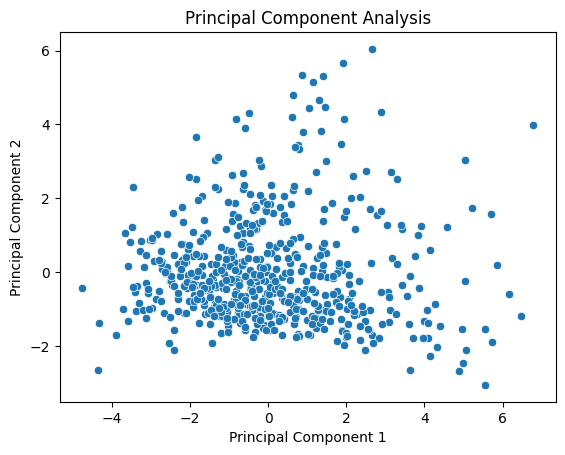

In [9]:
# Performing PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(np_standardized_df)
principal_df = pd.DataFrame(data= principal_components, columns= ['Principal Component 1', 'Principal Component 2'])
principal_df

sns.scatterplot(x= 'Principal Component 1', y= 'Principal Component 2', data = principal_df)
plt.title('Principal Component Analysis')

## Elbow Method
We used the elbow method to determine the optimal amount of cluster to use for this project. We plotted the inertia clusters at each amount of clusters up to 10. The inertia is the sum of the square distances of each point in a cluster from it centroid. We can see that the slope significant drops off at 5 clusters so we decided to use 5 clusters.

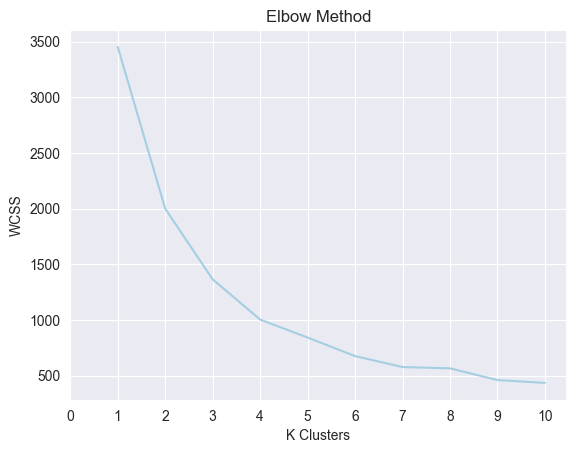

In [11]:
WCSS = []
for i in range(1,11):
    kmeans= KMeans(n_clusters= i)
    kmeans.fit_transform(principal_df)
    WCSS.append(kmeans.inertia_)

sns.set_style('darkgrid')
sns.set_palette('Paired')
plt.plot(range(1,11), WCSS)
plt.xticks(np.arange(0,11,1))
plt.ylabel('WCSS')
plt.xlabel('K Clusters')
plt.title('Elbow Method')
plt.show()

## K Means Clustering
We decided to use K Means Clustering to use find NBA Archetypes

In [17]:
# K Means Clustering
kmeans = KMeans(n_clusters = 5, init= 'k-means++', random_state= 42332)
kmeans.fit_transform(principal_df)
clustered_df = df_career_avg.copy()
clustered_df['Clusters'] = kmeans.labels_
clustered_df_group = clustered_df.drop(['PLAYER_ID', 'GP', 'PLAYER_NAME'], axis = 1).groupby('Clusters').mean().round(3)
clustered_df_group.head()

,REB,AST,STL,BLK,TOV,PTS,FG_PCT,3_PCT,FT_PCT
Clusters,,,,,,,,,
0,5.334,4.743,1.100,0.487,2.356,18.006,0.463,0.351,0.798
1,3.304,2.104,0.746,0.314,1.111,9.258,0.441,0.354,0.791
2,4.553,0.941,0.485,0.687,0.780,6.539,0.545,0.261,0.674
3,1.661,0.773,0.325,0.148,0.437,3.602,0.402,0.291,0.728
4,8.284,1.779,0.747,1.479,1.474,12.376,0.577,0.214,0.676


In [18]:
# Naming the Clusters
cluster_meaning = { 0 : "Scoring Shot Creator", 1 : "3 and D Wing", 2 : "Interior Role Player", 3 : "Energetic Role Player", 4 : "Defensive Anchor Big" } 
clustered_df['Clusters'] = clustered_df['Clusters'].replace(cluster_meaning)
clustered_df[['Principal Component 1', 'Principal Component 2']] = principal_df
clustered_df.head()

,PLAYER_ID,GP,REB,AST,STL,BLK,TOV,PTS,FG_PCT,3_PCT,FT_PCT,PLAYER_NAME,Clusters,Principal Component 1,Principal Component 2
0,1630173,394,5.8,1.0,0.6,0.7,1.0,7.6,0.488,0.297,0.608,Precious Achiuwa,Interior Role Player,-0.076682,1.690504
1,203500,769,8.0,1.5,0.8,0.9,1.4,8.8,0.586,0.059,0.535,Steven Adams,Defensive Anchor Big,0.888715,3.802615
2,1628389,573,8.9,3.6,1.1,0.9,2.2,15.8,0.535,0.317,0.758,Bam Adebayo,Scoring Shot Creator,3.425321,1.175199
3,1630534,286,2.8,1.2,0.6,0.5,0.8,7.2,0.440,0.336,0.713,Ochai Agbaji,3 and D Wing,-0.725519,0.135301
4,1630583,242,5.3,1.9,0.6,0.6,0.9,9.8,0.458,0.344,0.684,Santi Aldama,Interior Role Player,0.205048,0.695149


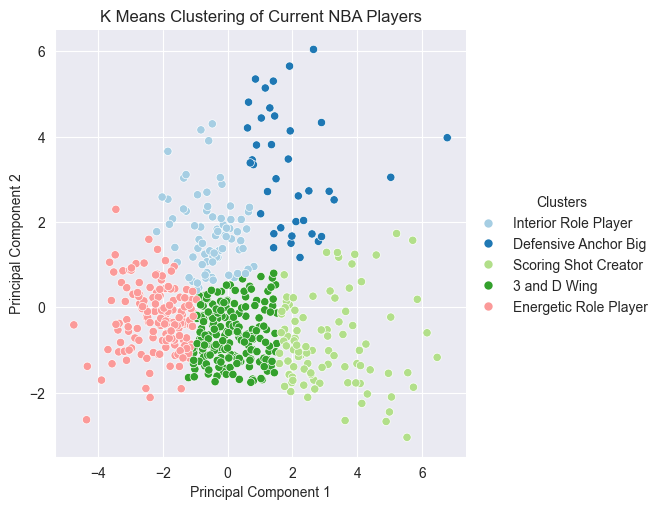

In [19]:
# Graphing the Clusters
sns.set_style('darkgrid')
sns.set_palette('Paired')
sns.relplot(x= 'Principal Component 1', y= 'Principal Component 2',  data= principal_df, hue = clustered_df['Clusters'])
plt.title('K Means Clustering of Current NBA Players')
plt.show()

### We also wanted to visualize what players defined an archetype through a hiearchical graph

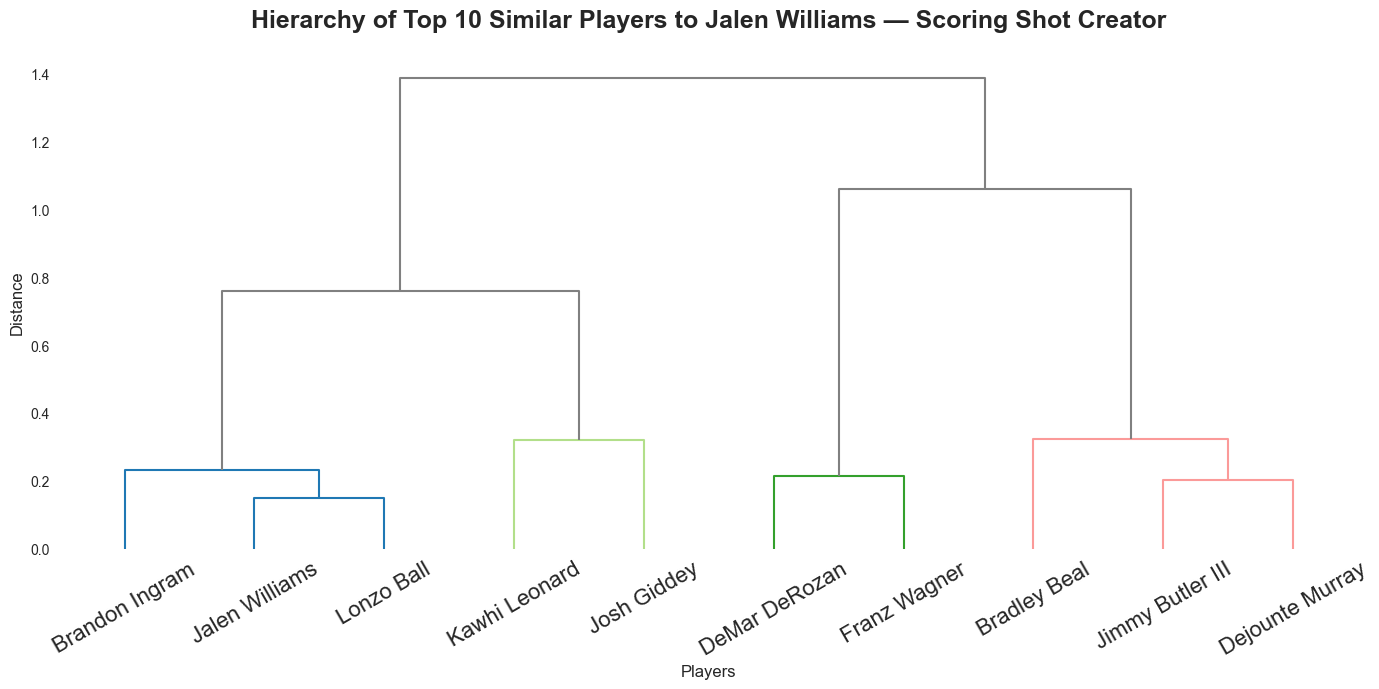

In [25]:
def plot_role_hierarchy(cluster_df, top_n=10):

    # find role-defining player
    X = cluster_df[['Principal Component 1', 'Principal Component 2']].values
    centroid = X.mean(axis=0)
    dist_to_centroid = cdist(X, [centroid], metric='euclidean').flatten()
    rep_idx = np.argmin(dist_to_centroid)
    rep_player = cluster_df.iloc[rep_idx]['PLAYER_NAME']

    # Distances from representative player
    rep_coords = X[rep_idx].reshape(1, -1)
    dist_from_rep = cdist(X, rep_coords, metric='euclidean').flatten()

    cluster_df = cluster_df.copy()
    cluster_df['rep_distance'] = dist_from_rep
    cluster_top = cluster_df.sort_values('rep_distance').iloc[:top_n]

    X_top = cluster_top[['Principal Component 1', 'Principal Component 2']].values
 
    Z = linkage(X_top, method='ward')

    
    plt.figure(figsize=(14, 7))

    dendrogram(
        Z,
        labels=cluster_top['PLAYER_NAME'].tolist(),
        leaf_rotation=30,     
        leaf_font_size=16,   
        color_threshold=0.4 * max(Z[:, 2]),  
        above_threshold_color="gray"
    )

    
    plt.title(f"Hierarchy of Top {top_n} Similar Players to {rep_player} — {cluster_top['Clusters'].iloc[0]}",
              fontsize=18, fontweight='bold', pad=20)
    plt.xlabel("Players", fontsize=12)
    plt.ylabel("Distance", fontsize=12)
    plt.grid(False)                   
    plt.box(False)                     
    plt.tight_layout()

plot_role_hierarchy(clustered_df[clustered_df['Clusters'] == 'Scoring Shot Creator'].reset_index(drop=True))

## K Nearest Neighbors
We decided to also use the unsupervised version of K Nearest Neighbors to find 5 statistically most similar players to a certain player. We visualized these similararities using a radar chart.

In [20]:
# K Nearest Neighbors
KNN = NearestNeighbors(n_neighbors = 6, metric='euclidean')
KNN.fit(clustered_df[['Principal Component 1', 'Principal Component 2']])
player_coords = clustered_df.loc[clustered_df['PLAYER_NAME'] == 'Stephen Curry'][['Principal Component 1', 'Principal Component 2']]
distances, indices = KNN.kneighbors(player_coords)
selected_df = clustered_df.iloc[indices[0]].reset_index().drop(0)
selected_df.head()

,index,PLAYER_ID,GP,REB,AST,STL,BLK,TOV,PTS,FG_PCT,3_PCT,FT_PCT,PLAYER_NAME,Clusters,Principal Component 1,Principal Component 2
1,385,101108,1359,4.4,9.2,2.0,0.2,2.3,16.9,0.469,0.370,0.871,Chris Paul,Scoring Shot Creator,4.890880,-2.674348
2,19,1630163,237,6.0,7.5,1.5,0.3,3.3,21.1,0.422,0.364,0.836,LaMelo Ball,Scoring Shot Creator,5.054927,-2.101182
3,188,1630169,410,3.7,8.7,1.5,0.6,2.2,17.1,0.476,0.395,0.853,Tyrese Haliburton,Scoring Shot Creator,4.312034,-2.030074
4,564,1629027,488,3.5,9.8,1.0,0.2,4.2,25.2,0.432,0.351,0.873,Trae Young,Scoring Shot Creator,5.534934,-3.046084
5,297,203081,900,4.3,6.7,1.0,0.3,2.8,25.1,0.439,0.371,0.899,Damian Lillard,Scoring Shot Creator,4.140005,-2.251221


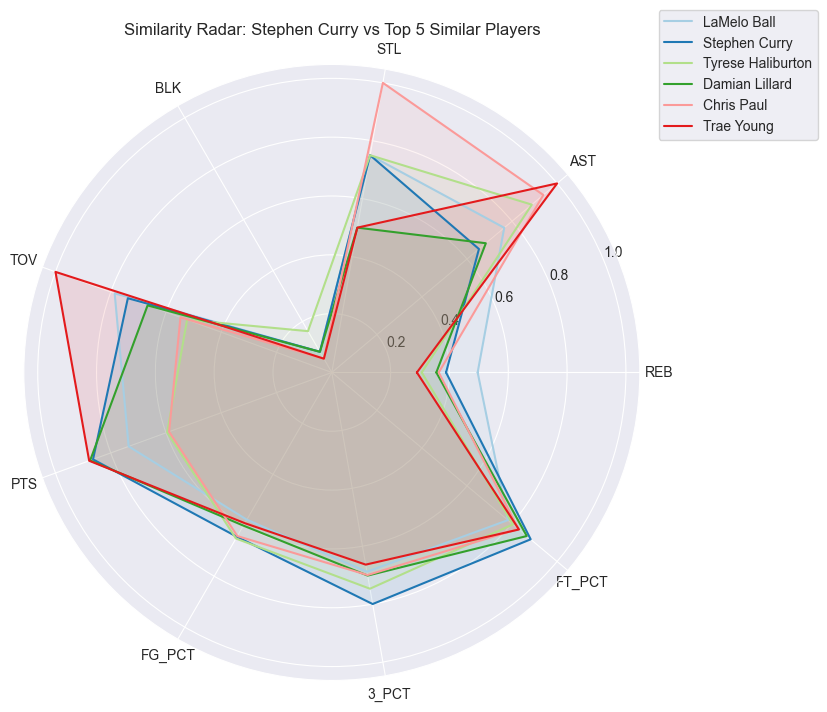

In [21]:
# Radar Chart: Made a function for future use

def plot_similarity_radar(df, target_player, stats, player_indices):

    labels = list(stats)
    players_to_plot = [target_player] + df['PLAYER_NAME'].iloc[player_indices].tolist()
    df_plot = df[df['PLAYER_NAME'].isin(players_to_plot)].copy()
    df_norm = df_plot.copy()

    for stat in labels:
        df_norm[stat] = (df_plot[stat] - df[stat].min()) / (df[stat].max() - df[stat].min())

    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

    plt.figure(figsize=(8, 8))

    for i, row in df_norm.iterrows():
        values = row[labels].tolist()
        values += values[:1]
        plt.polar(angles, values, label=row['PLAYER_NAME'])
        plt.fill(angles, values, alpha=0.1)
    
    plt.xticks(angles[:-1], labels)
    plt.title(f"Similarity Radar: {target_player} vs Top 5 Similar Players")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.show()

plot_similarity_radar(clustered_df, 'Stephen Curry', clustered_df.loc[:, "REB": "FT_PCT"], indices[0])